#### Avery Jonas
Spatial Statistics (INFO-615)
Final Project

## Spatial Distribution of Internet Access in 2021

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import Point
from IPython.core.pylabtools import figsize
figsize(8,8)
from pointpats import centrography
import libpysal
from scipy import stats
from tobler.util import h3fy
from pointpats import distance_statistics
import fiona
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import Point
from IPython.core.pylabtools import figsize
figsize(8,8)
from pointpats import centrography
import libpysal
from scipy import stats
from tobler.util import h3fy
from pointpats import distance_statistics
from pysal.lib import weights
from pysal.explore import esda
from libpysal.weights import attach_islands

/opt/miniconda3/envs/info615/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
df = pd.read_csv("../data/transformed/3i-index-data.csv")

In [3]:
df = df.copy()

In [4]:
df = df.query("Edition == 'E5'")

In [5]:
df.head()

,Country,Edition,1.1.1) Internet users,1.1.2) Fixed-line broadband subscribers,1.1.3) Mobile subscribers,1.1.4) Gender gap in internet access,1.1.5) Gender gap in mobile phone access,1.2.1) Average fixed broadband upload speed,1.2.2) Average fixed broadband download speed,1.2.3) Average fixed broadband latency,...,BG15) Internet users (population),BG16) Offline population,BG17) Internet access gender gap,BG18) Mobile phone access gender gap,BG19) Internet users (percent of population),BG20) Male internet users,BG21) Female internet users,BG22) Male mobile phone subscribers,BG23) Female mobile phone subscribers,BG24) Total fixed line broadband subscribers
4,Algeria,E5,74.4,8.32,109.4,10.9,8.0,1.41,3.84,54.09,...,20.64,21.45,7.0,7.0,49.0,64.0,57.0,87.0,80.0,3582739
9,Angola,E5,11.3,0.37,46.6,30.6,14.4,6.72,14.46,33.62,...,4.28,25.54,10.5,10.1,14.3,37.3,26.9,75.1,65.0,119047
14,Argentina,E5,75.9,19.64,125.8,-2.6,-2.4,9.67,38.99,32.88,...,32.65,11.29,-2.0,-2.0,74.3,77.0,79.0,83.0,85.0,8793181
19,Australia,E5,86.1,34.73,110.6,2.1,2.2,20.80,46.55,24.71,...,21.28,3.31,2.0,2.0,86.5,94.0,92.0,93.0,91.0,8705523
24,Austria,E5,89.9,28.13,119.8,2.2,-1.0,17.04,59.44,22.27,...,7.59,1.06,2.0,-1.0,87.8,91.0,89.0,96.0,97.0,2513000


In [6]:
file = "../data/raw/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
countries_gdf = gpd.read_file(file)
countries_gdf = countries_gdf.copy()

In [7]:
countries_gdf.crs = 6933

ne_50m_admin_0_countries.zip

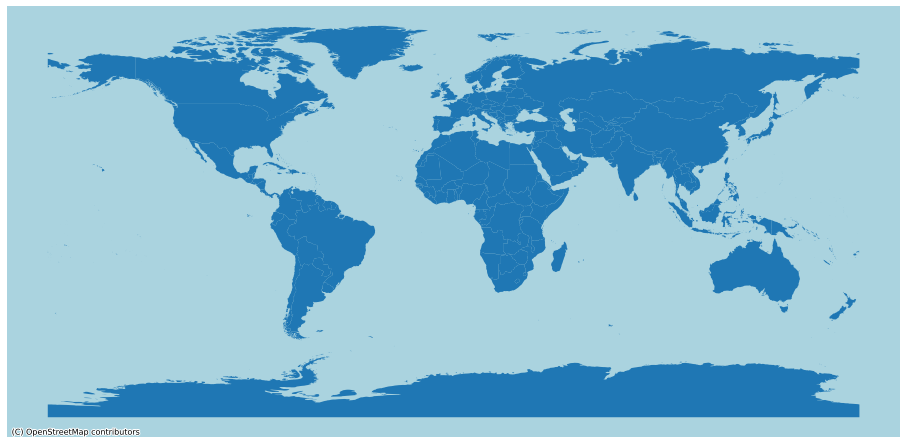

In [8]:
ax = countries_gdf.plot(markersize=5, figsize=(16, 8))
cx.add_basemap(ax, crs=countries_gdf.crs,
               source = cx.providers.OpenStreetMap.Mapnik)
ax.axis('off');

In [9]:
countries_gdf.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,None,None,None,None,None,None,None,None,None,"POLYGON ((31.288 -22.402, 31.197 -22.345, 31.0..."
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,None,None,None,None,None,None,None,None,None,"POLYGON ((30.396 -15.643, 30.251 -15.643, 29.9..."
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((53.086 16.648, 52.581 16.470, ..."
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((104.064 10.391, 104.083 10.341..."
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-60.821 9.138, -60.941 9.106, ..."


In [10]:
countries_gdf['Country'] = countries_gdf['SOVEREIGNT'].astype("string")

In [11]:
countries_gdf['Country'] = countries_gdf['Country'].replace(['Democratic Republic of the Congo'], 'Congo (DRC)')

In [12]:
countries_gdf['Country'] = countries_gdf['Country'].replace(['United States of America'], 'United States')

In [13]:
countries_gdf['Country'] = countries_gdf['Country'].replace(['United Republic of Tanzania'], 'Tanzania')

In [14]:
countries_gdf['Country'] = countries_gdf['Country'].replace(['Czechia'], 'Czech Republic')

In [15]:
countries_gdf.dtypes

featurecla      object
scalerank        int64
LABELRANK        int64
SOVEREIGNT      object
SOV_A3          object
                ...   
FCLASS_SE       object
FCLASS_BD       object
FCLASS_UA       object
geometry      geometry
Country         string
Length: 163, dtype: object

In [16]:
df.dtypes

Country                                          object
Edition                                          object
1.1.1) Internet users                           float64
1.1.2) Fixed-line broadband subscribers         float64
1.1.3) Mobile subscribers                       float64
                                                 ...   
BG20) Male internet users                       float64
BG21) Female internet users                     float64
BG22) Male mobile phone subscribers             float64
BG23) Female mobile phone subscribers           float64
BG24) Total fixed line broadband subscribers      int64
Length: 86, dtype: object

In [17]:
df = pd.merge(df, countries_gdf, how='right', on='Country')

In [18]:
df.head()

,Country,Edition,1.1.1) Internet users,1.1.2) Fixed-line broadband subscribers,1.1.3) Mobile subscribers,1.1.4) Gender gap in internet access,1.1.5) Gender gap in mobile phone access,1.2.1) Average fixed broadband upload speed,1.2.2) Average fixed broadband download speed,1.2.3) Average fixed broadband latency,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Zimbabwe,E5,30.3,1.40,90.1,13.2,-3.7,13.30,13.46,51.66,...,None,None,None,None,None,None,None,None,None,"POLYGON ((31.288 -22.402, 31.197 -22.345, 31.0..."
1,Zambia,E5,17.7,0.50,96.4,27.8,13.9,12.25,12.35,49.89,...,None,None,None,None,None,None,None,None,None,"POLYGON ((30.396 -15.643, 30.251 -15.643, 29.9..."
2,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((53.086 16.648, 52.581 16.470, ..."
3,Vietnam,E5,46.0,15.35,141.2,13.6,4.2,52.07,50.14,8.85,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((104.064 10.391, 104.083 10.341..."
4,Venezuela,E5,33.5,8.98,47.3,-16.4,-14.1,2.06,4.12,137.07,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-60.821 9.138, -60.941 9.106, ..."


In [19]:
gdf = gpd.GeoDataFrame(df, geometry = 'geometry')

In [20]:
gdf.crs=6933

In [21]:
gdf = gdf.dropna(subset=['BG15) Internet users (population)'])

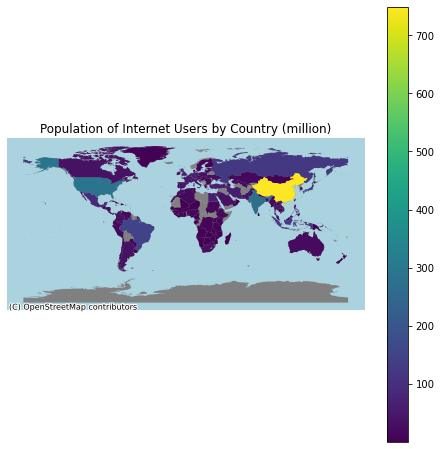

In [22]:
ax = countries_gdf.plot(color="grey")
gdf.plot(ax=ax, column=gdf['BG15) Internet users (population)'], figsize=(16, 8), edgecolor="none", legend=True)
cx.add_basemap(ax, crs=gdf.crs.to_string(),
               source = cx.providers.OpenStreetMap.Mapnik)
ax.axis('off');
plt.title("Population of Internet Users by Country (million)");

Bolivia, Libya, Chad, Yemen, Guyana, Suriname, French Guiana, South Sudan, Tajikistan, Turkmenistan, Afghanistan, Kyrgyzstan, Belarus, Norway, Moldova, Georgia, Armenia, Iceland, Bosnia, Montenegro, Albania, Serbia, North Macedonia, Iraq, Syria, Mauritania, and Guinea-Bissau are not included in dataset.

In [23]:
w = weights.KNN.from_dataframe(gdf, k =6)

In [24]:
w.transform = 'R'

In [25]:
moran = esda.moran.Moran(gdf['BG15) Internet users (population)'], w, permutations=9999)

In [26]:
moran.I

0.19341310397698794

no global spatial autocorrelation

In [27]:
moran.p_sim

0.0009

In [28]:
local_moran = esda.moran.Moran_Local(gdf['BG15) Internet users (population)'], w, permutations=9999)

In [29]:
gdf['local_moran_Is'] = local_moran.Is

In [30]:
gdf['local_moran_p_value'] = local_moran.p_sim

In [31]:
gdf['local_moran_quadrant'] = local_moran.q

In [32]:
alpha = 0.05
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


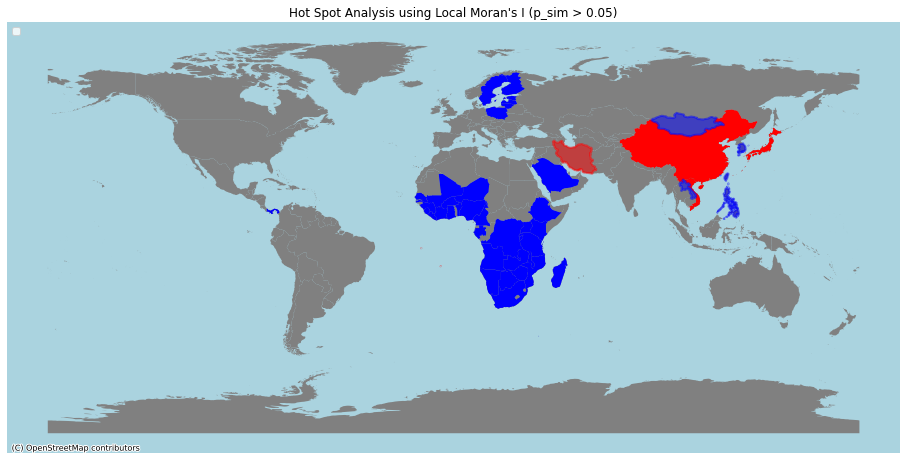

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='white', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.05)");

In [34]:
alpha = 0.01
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


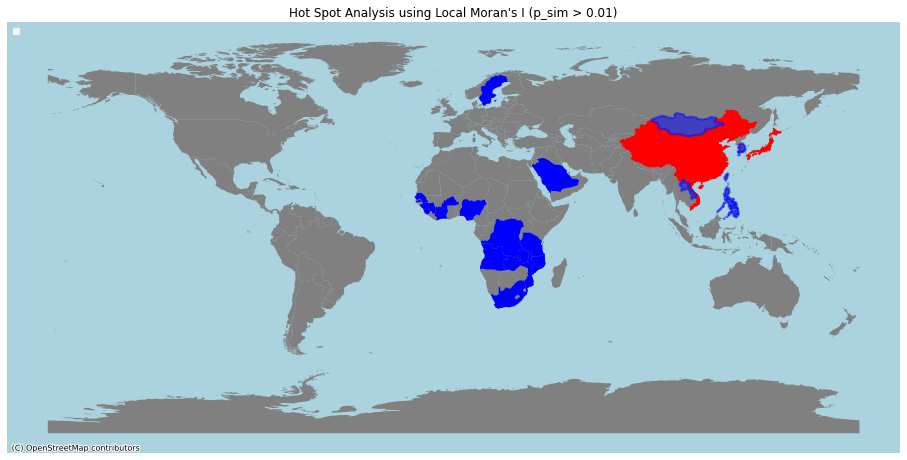

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='grey', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.01)");

In [36]:
alpha = 0.001
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


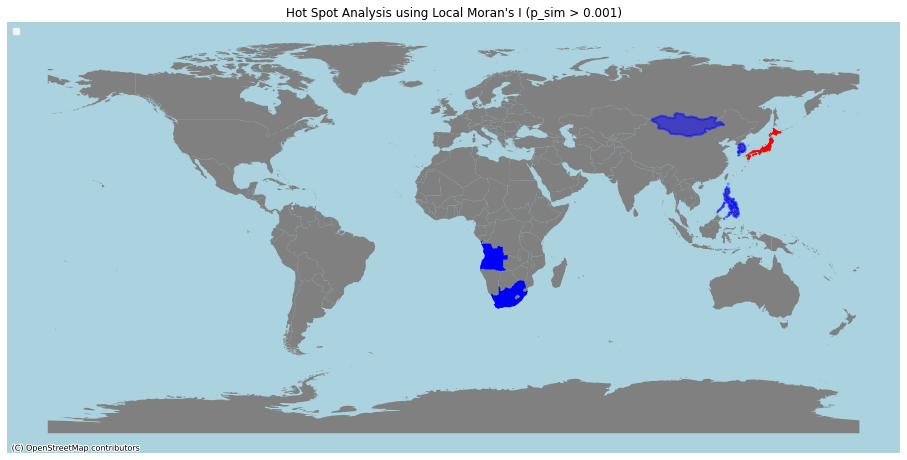

In [37]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='grey', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.001)");

Text(0.5, 1.0, 'Internet Users by Country (percentage)')

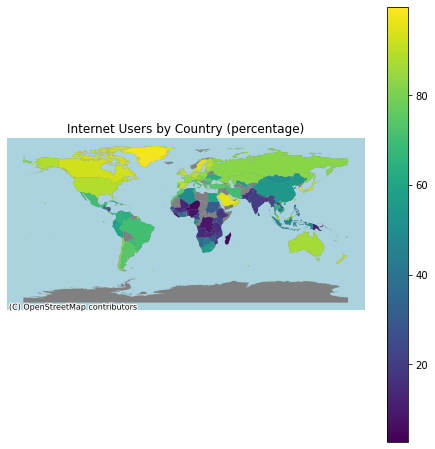

In [38]:
ax = countries_gdf.plot(color="grey")
gdf.plot(ax=ax, column=gdf['BG19) Internet users (percent of population)'], figsize=(16, 8), edgecolor="none", legend=True)
cx.add_basemap(ax, crs=gdf.crs.to_string(),
               source = cx.providers.OpenStreetMap.Mapnik)
ax.axis('off');
plt.title("Internet Users by Country (percentage)")

In [39]:
moran = esda.moran.Moran(gdf['BG19) Internet users (percent of population)'], w, permutations=9999)

In [40]:
moran.I

0.7050601671359186

positive spatial auto correlation

In [41]:
moran.p_sim

0.0001

In [42]:
local_moran = esda.moran.Moran_Local(gdf['BG19) Internet users (percent of population)'], w, permutations=9999)

In [43]:
gdf['local_moran_Is'] = local_moran.Is

In [44]:
gdf['local_moran_p_value'] = local_moran.p_sim

In [45]:
gdf['local_moran_quadrant'] = local_moran.q

In [46]:
alpha = 0.05
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


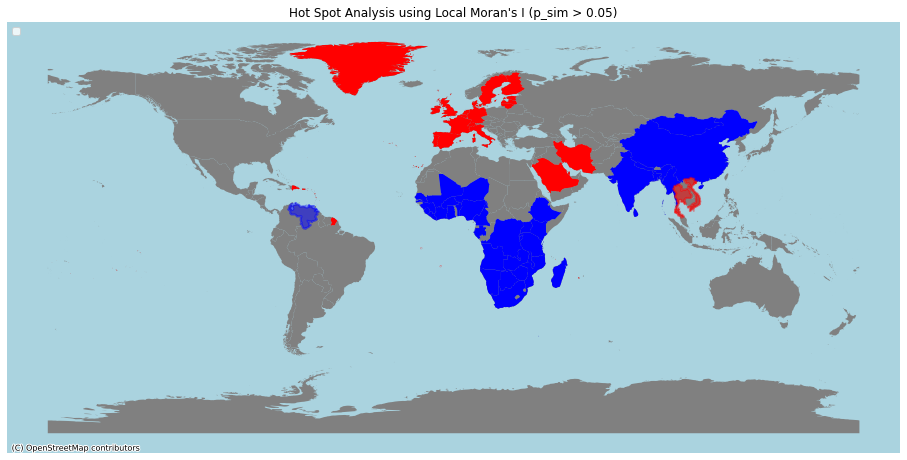

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='white', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.05)");

In [48]:
alpha = 0.001
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


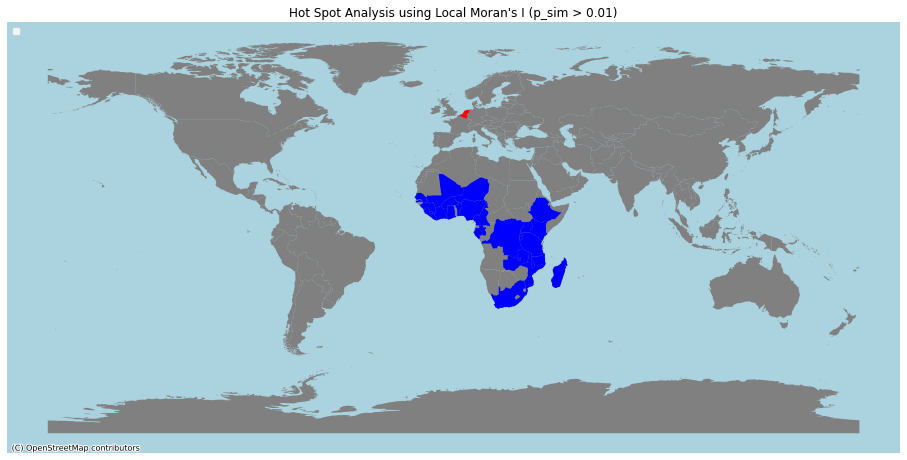

In [49]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='grey', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.01)");

In [50]:
alpha = 0.001
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


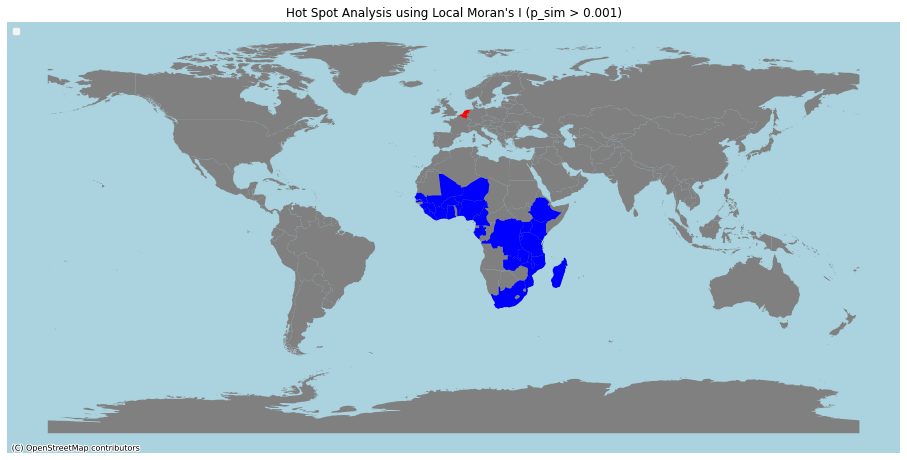

In [51]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='grey', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.001)");

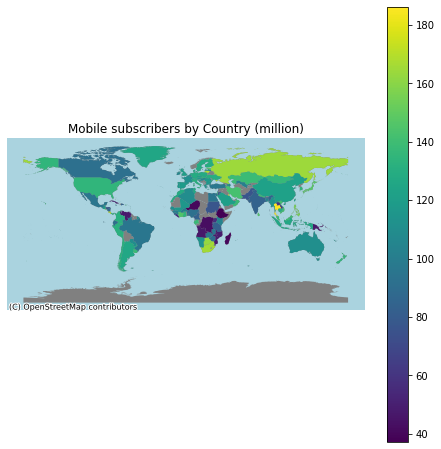

In [52]:
ax = countries_gdf.plot(color="grey")
gdf.plot(ax=ax, column=gdf['1.1.3) Mobile subscribers'], figsize=(16, 8), edgecolor="none", legend=True)
cx.add_basemap(ax, crs=gdf.crs.to_string(),
               source = cx.providers.OpenStreetMap.Mapnik)
ax.axis('off');
plt.title("Mobile subscribers by Country (million)");

In [53]:
moran = esda.moran.Moran(gdf['1.1.3) Mobile subscribers'], w, permutations=9999)

In [54]:
moran.I

0.22744769752415608

very low global auto correlation

In [55]:
moran.p_sim

0.0001

In [56]:
local_moran = esda.moran.Moran_Local(gdf['1.1.3) Mobile subscribers'], w, permutations=9999)

In [57]:
gdf['local_moran_Is'] = local_moran.Is

In [58]:
gdf['local_moran_p_value'] = local_moran.p_sim

In [59]:
gdf['local_moran_quadrant'] = local_moran.q

In [60]:
alpha = 0.05
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


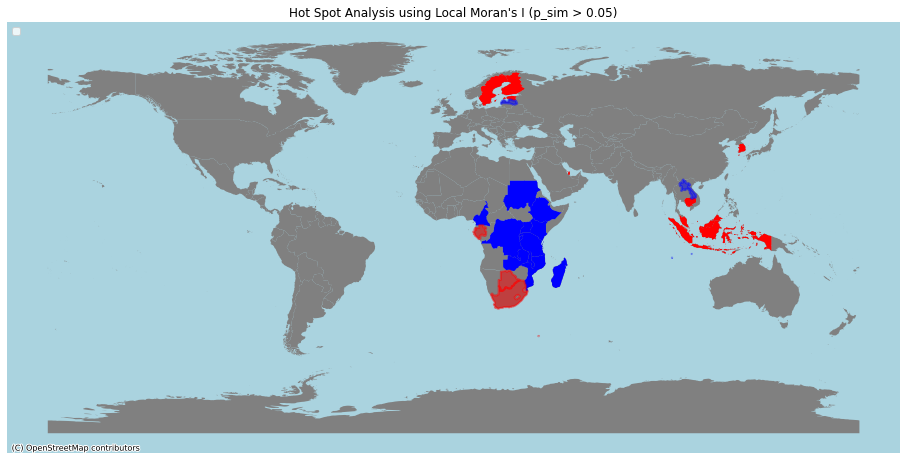

In [61]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='white', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.05)");

In [62]:
alpha = 0.01
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


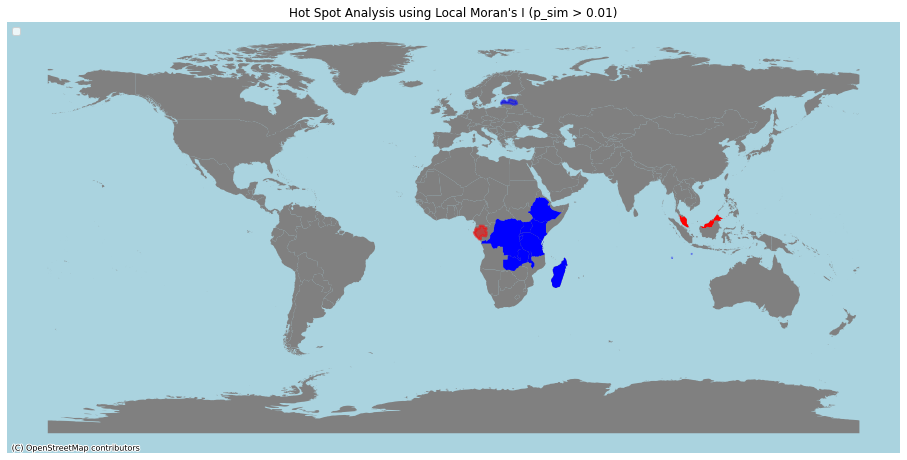

In [63]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='white', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.01)");

In [64]:
alpha = 0.001
hotspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

No handles with labels found to put in legend.


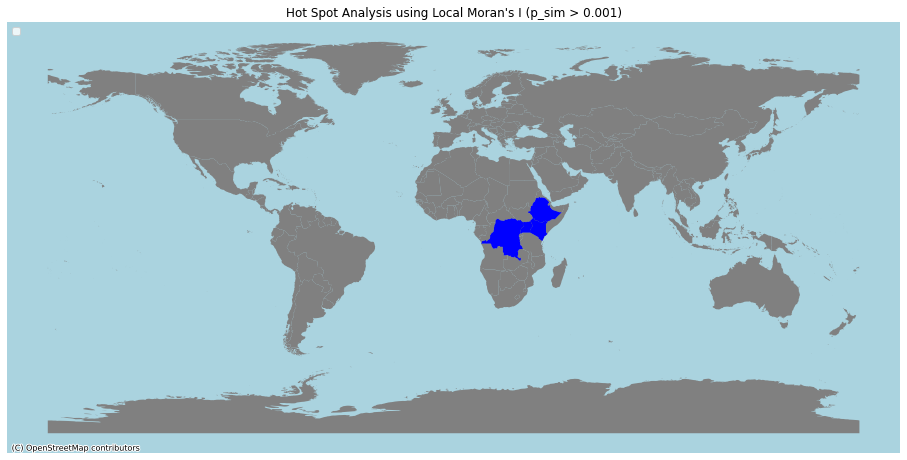

In [65]:
fig, ax = plt.subplots(figsize=(16, 8))
countries_gdf.plot(ax=ax,color="grey")
gdf.plot(ax=ax, facecolor='white', alpha=0)
hotspots.plot(color='red', ax=ax, label='Hot Spots')
coldspots.plot(color='blue', ax=ax, label='Cold Spots')
doughnuts.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
ax.legend(loc="upper left")
ax.axis('off')
plt.title("Hot Spot Analysis using Local Moran's I (p_sim > 0.001)");